### Convolutional Neural Network & Computer Vision with Tensorflow

**Getting data**

In [1]:
# DL needs
import tensorflow as tf
import tensorflow.keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

# for os interactions
import os

2025-03-10 16:41:38.083133: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**5. Multiclass image classification**

* Here we will be classifying amongst 10 different classes of food
  (https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip)

In [3]:
import os 

# walkthrough 10 classes of food image data
for dirpath,dirnames,filenames in os.walk('10_food_classes_all_data'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_all_data'
There are 10 directories and 0 images in '10_food_classes_all_data/test'
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'
There are 10 directori

In [5]:
# setup paths to data directory
train_dir='10_food_classes_all_data/train'
test_dir='10_food_classes_all_data/test'

# getting the sub-dirs to get classnames
import pathlib
datadir = pathlib.Path(train_dir)
class_names=np.array(sorted([item.name for item in datadir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (512, 512, 3)


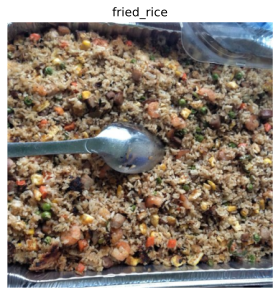

In [250]:
# visualize, visualize, visualize

import matplotlib.image as mpimg
import random

def view_random_image(target_dir,target_class):
    # setup target directory
    target_folder=target_dir+"/"+target_class

    # get a random image path
    random_img=random.sample(os.listdir(target_folder),1)
    img=mpimg.imread(target_folder+"/"+random_img[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    print(f'Image shape: {img.shape}')
    return img

img=(view_random_image(train_dir,target_class=random.choice(class_names)))

In [41]:
# Pre-process the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale = 1/255.0)
valid_datagen=ImageDataGenerator(rescale=1/255.0,)

train_data=train_datagen.flow_from_directory(directory=train_dir,
                                             batch_size=32, # mini batch size
                                             target_size=(224,224), # target size of images (h,w) 
                                             class_mode="categorical", # 'categorical' (default), 'binary',..
                                             seed = random_seed,
                                             shuffle=True 
                                             )

valid_data=valid_datagen.flow_from_directory(directory=test_dir,
                                             batch_size=32,
                                             target_size=(224,224),
                                             class_mode="categorical",
                                             seed = random_seed,
                                             shuffle=False 
                                             )


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


**`getattr(object, attribute_name, default_value)`**

In [129]:
# creating a CNN model (baseline: tinyVGG)
class tinyVGG(kr.Model):
    def __init__(self,model_name='model_1',lr=0.001,metrics=['accuracy']):
        # calling constructor of kr.Model() class
        super().__init__(name=model_name)


        # defining model layers

        ### CONV-POOL 1
        self.cnn1 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,padding='valid',
                                           input_shape=(224,224,3),name='conv_1')
        self.cnn2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,name='conv_2')
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2,
                                               padding='valid',name='pool_1')
        
        ### CONV-POOL 2
        self.cnn3 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,name='conv_3')
        self.cnn4 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,name='conv_4')
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2,name='pool_2')

        ### FLATTEN
        self.flatten1 = tf.keras.layers.Flatten(name='flatten_1')

        ### output layer
        self.output_layer = tf.keras.layers.Dense(10,name='output_layer')


        # layers:
        self._layers = [self.cnn1, self.cnn2, self.pool1,
                       self.cnn3, self.cnn4, self.pool2,
                       self.flatten1,
                       self.output_layer
                       ]
        
        # activations
        self.activations = {
            'conv_1':'relu',
            'conv_2':'relu',
            'pool_1':None,
            'conv_3':'relu',
            'conv_4':'relu',
            'pool_2':None,
            'flatten_1':None,
            'output_layer':'softmax'
        }

        # outputs & tracking
        self.track_layer_output = False
        self.track_activation_output = False
        self.layer_outputs=[]
        self.activation_outputs=[]
        

        ### other hyperparams
        self.loss_function = 'categorical_crossentropy',
        self.optimizer = kr.optimizers.Adam(learning_rate=lr)
        self.eval_metrics = metrics
        

        ### build the model
        self.build()

    
    def build(self):
        inputs=tf.keras.Input(shape=[224,224,3])
        x=self._layers[0](inputs)
        for layer in self._layers[1:]:
            x=layer(x)
    
    def call(self,inputs,training=True):
        x = inputs
        layer_outputs=[]
        activation_outputs=[]

        for layer in self._layers:
            # forward pass and appending output of each layer and activation
            x = layer(x)
            
            if self.track_layer_output:
                layer_outputs.append(x)

            x = self.get_activation(layer_name=layer.name)(x)
            
            if self.track_activation_output:
                activation_outputs.append(x)

        self.layer_outputs=layer_outputs
        self.activation_outputs=activation_outputs

        output = x
        return output


    def get_activation(self,layer_name):
        activation_name = self.activations.get(layer_name,None)
        def activation(input):
            if activation_name == None:
                    return input
            else:
                function = getattr(tf.nn,activation_name,None)
                return input if function is None else function(input)
        return activation

In [ ]:
model_1=tinyVGG(model_name='model_1')
model_1.track_layer_output=True
model_1.track_activation_output=True

**6) Visualizing each layer and activation output**

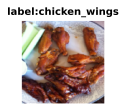

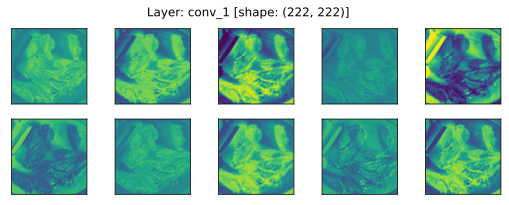

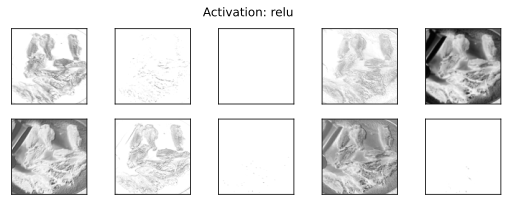

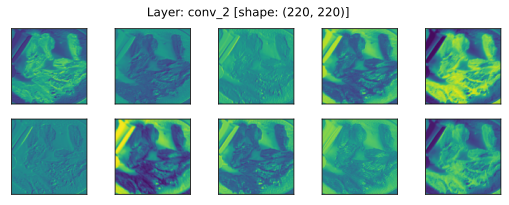

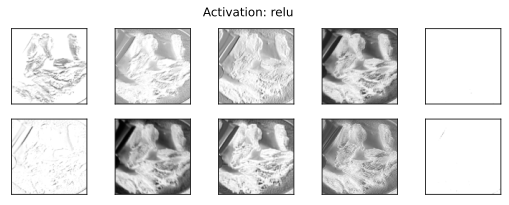

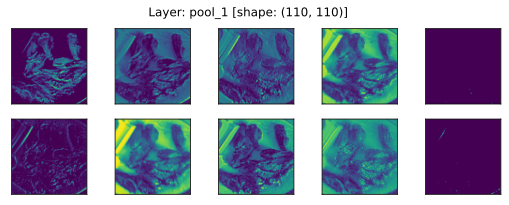

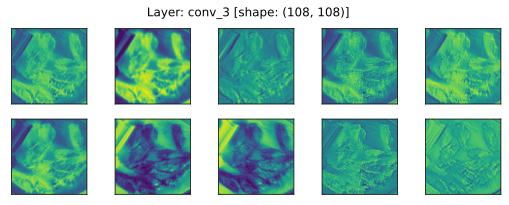

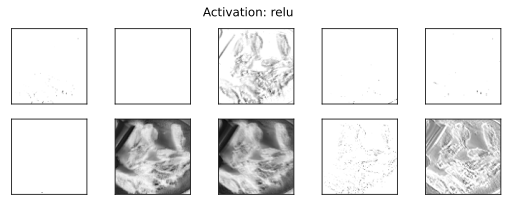

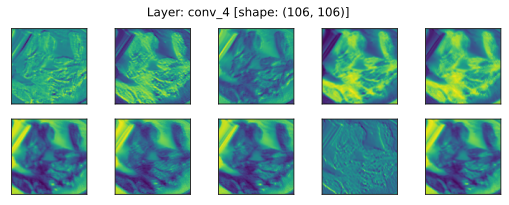

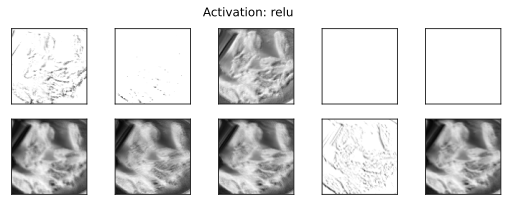

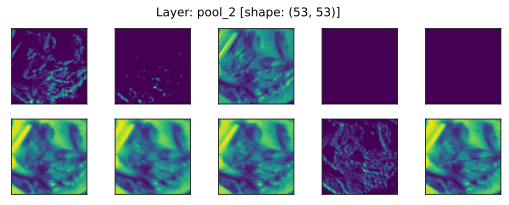

In [220]:
# visualizing before training
img_num = np.random.randint(0,32)
img_data,img_label=train_data.__next__()

img=tf.expand_dims(img_data[img_num],0)
model_1(img,training=False)

# visualizing each layer/activation output
plt.figure(figsize=(1.5,1.5))
plt.imshow(tf.squeeze(img))
plt.axis('off')
plt.title(f'label:{class_names[tf.argmax(img_label[img_num])]}',fontsize=10,fontweight='bold')
plt.show()

for i,(layer_o) in enumerate(model_1.layer_outputs[:-2]):
    ### layers
    layer_o=tf.squeeze(layer_o)
    fig,axs = plt.subplots(2,int(layer_o.shape[2]/2),figsize=(9,3))
    for l_i,ax in enumerate(axs.flatten()):
        ax.imshow(layer_o[:,:,l_i])
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(f'Layer: {model_1._layers[i].name} [shape: {layer_o[:,:,l_i].shape}]')


    if model_1.activations[model_1._layers[i].name]!=None:
        act_o=tf.squeeze(model_1.activation_outputs[i])
        fig,axs = plt.subplots(2,int(layer_o.shape[2]/2),figsize=(9,3))
        for l_i,ax in enumerate(axs.flatten()):
            ax.imshow(act_o[:,:,l_i],cmap='binary')
            ax.set_xticks([])
            ax.set_yticks([])
        fig.suptitle(f'Activation: {model_1.activations[model_1._layers[i].name]}')

In [222]:
model_1.compile(loss=model_1.loss_function,optimizer=model_1.optimizer,metrics=model_1.eval_metrics)
model_1.summary(show_trainable=True)
history_1 = model_1.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data)
            )

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ conv_1 (Conv2D)             │ (None, 222, 222, 10)  │        280 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_2 (Conv2D)             │ (None, 220, 220, 10)  │        910 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pool_1 (MaxPooling2D)       │ (None, 110, 110, 10)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_3 (Conv2D)             │ (None, 108, 108, 10)  │        910 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_4 (Conv2D)             │ (None, 106, 106, 10)  │        910 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pool_2 (MaxPooling2D)       │ (None, 53, 53, 10)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 28090)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ output_layer (Dense)        │ (None, 10)            │    280,910 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 283,920 (1.08 MB)

 Trainable params: 283,920 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 168s 710ms/step - accuracy: 0.1415 - loss: 2.3723 - val_accuracy: 0.2096 - val_loss: 2.1160
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 167s 709ms/step - accuracy: 0.2603 - loss: 2.0662 - val_accuracy: 0.2780 - val_loss: 2.0124
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 167s 711ms/step - accuracy: 0.3762 - loss: 1.8032 - val_accuracy: 0.3236 - val_loss: 1.9785
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 167s 712ms/step - accuracy: 0.5721 - loss: 1.2958 - val_accuracy: 0.2852 - val_loss: 2.3048
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 168s 714ms/step - accuracy: 0.7932 - loss: 0.6674 - val_accuracy: 0.2748 - val_loss: 3.0725


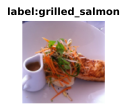

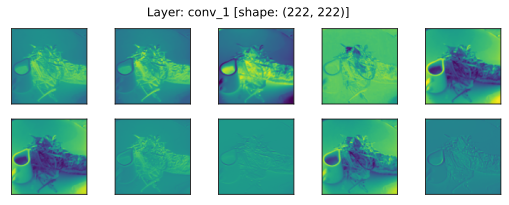

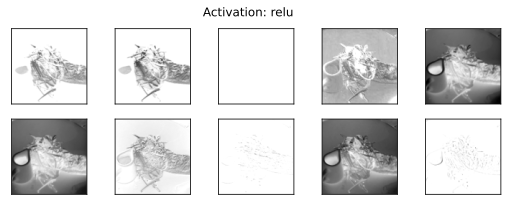

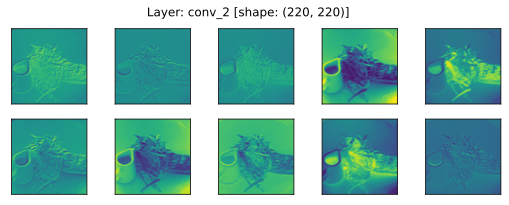

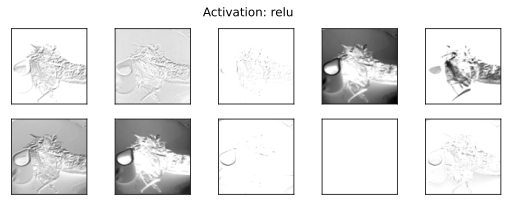

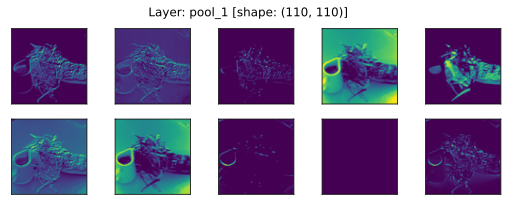

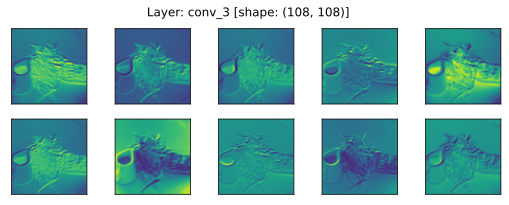

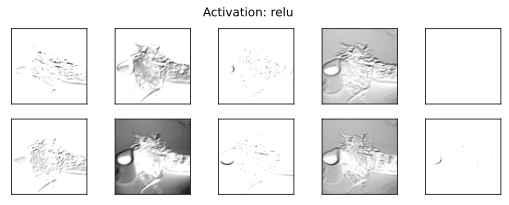

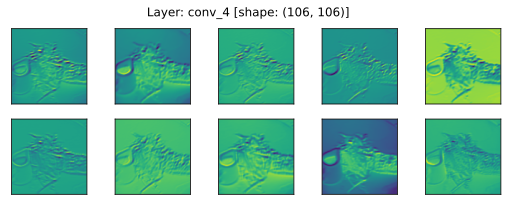

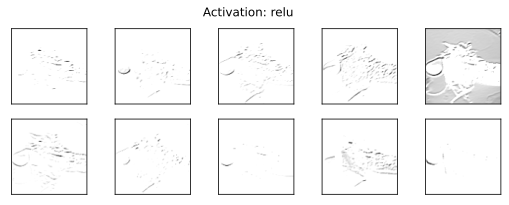

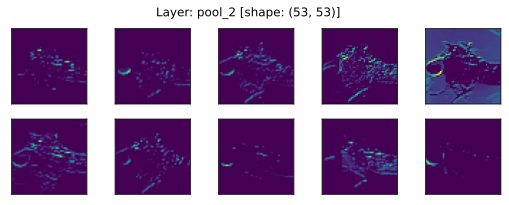

In [233]:
# visualizing after training
img_num = np.random.randint(0,32)
img_data,img_label=train_data.__next__()

img=tf.expand_dims(img_data[img_num],0)
model_1(img,training=False)

# visualizing each layer/activation output
plt.figure(figsize=(1.5,1.5))
plt.imshow(tf.squeeze(img))
plt.axis('off')
plt.title(f'label:{class_names[tf.argmax(img_label[img_num])]}',fontsize=10,fontweight='bold')
plt.show()

for i,(layer_o) in enumerate(model_1.layer_outputs[:-2]):
    ### layers
    layer_o=tf.squeeze(layer_o)
    fig,axs = plt.subplots(2,int(layer_o.shape[2]/2),figsize=(9,3))
    for l_i,ax in enumerate(axs.flatten()):
        ax.imshow(layer_o[:,:,l_i])
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(f'Layer: {model_1._layers[i].name} [shape: {layer_o[:,:,l_i].shape}]')


    if model_1.activations[model_1._layers[i].name]!=None:
        act_o=tf.squeeze(model_1.activation_outputs[i])
        fig,axs = plt.subplots(2,int(layer_o.shape[2]/2),figsize=(9,3))
        for l_i,ax in enumerate(axs.flatten()):
            ax.imshow(act_o[:,:,l_i],cmap='binary')
            ax.set_xticks([])
            ax.set_yticks([])
        fig.suptitle(f'Activation: {model_1.activations[model_1._layers[i].name]}')

In [230]:
# evaluating model

model_1.evaluate(valid_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.2843 - loss: 2.9079


[3.0725364685058594, 0.27480000257492065]

In [231]:
# plotting validation and training curves separately

def plot_loss_curves(history):
    # loss
    loss=history.history["loss"]
    val_loss=history.history['val_loss']

    # accuracy
    accuracy=tf.multiply(history.history['accuracy'],100)
    val_accuracy=tf.multiply(history.history['val_accuracy'],100)
    
    min_loss=tf.reduce_min(loss)
    min_val_loss=tf.reduce_min(val_loss)
    loc_loss=tf.argmin(loss)+1
    loc_val_loss=tf.argmin(val_loss)+1

    max_accuracy=tf.reduce_max(accuracy)
    max_val_accuracy=tf.reduce_max(val_accuracy)
    loc_acc=tf.argmax(accuracy)+1
    loc_val_acc=tf.argmax(val_accuracy)+1

    epochs = range(1,len(history.history["loss"])+1) # length of one of history object


    # plotting
    plt.figure()
    fig,axs=plt.subplots(1,2,figsize=(8,3))
    
    # loss
    axs[0].plot(epochs,loss,label=f'training loss (min:{min_loss:.2f})')
    axs[0].scatter(loc_loss,min_loss,s=30,color=(1,0,0))
    axs[0].plot(epochs,val_loss,label=f'validation loss (min:{min_val_loss:.2f})')
    axs[0].scatter(loc_val_loss,min_val_loss,s=30,color=(1,0,0))
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training & Validation')
    axs[0].legend()

    # accuracy
    axs[1].plot(epochs,accuracy,label=f'training accuracy (max:{max_accuracy:.2f}%)')
    axs[1].scatter(loc_acc,max_accuracy,s=30,color=(0,1,0))
    axs[1].plot(epochs,val_accuracy,label=f'validation accuracy (max:{max_val_accuracy:.2f}%)')
    axs[1].scatter(loc_val_acc,max_val_accuracy,s=30,color=(0,1,0))
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss/Accuracy')
    axs[1].set_title('Training & Validation')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

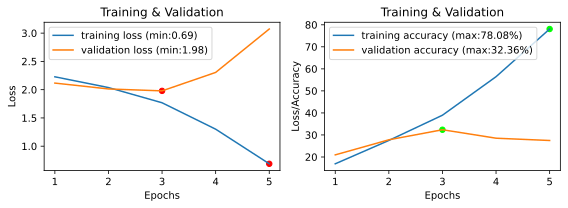

In [232]:
plot_loss_curves(history_1)

**observation**: 
* As the training loss goes down, the validation loss is not decreasing, i.e. model is overfitting
* Similarly with increase in training accuracy the test accuracy doesn't increase
* Model fails to generalize

**soln to attempt**:
* Remove two convolution layers (conv2 and conv4) 

***-- CONTD IN NEXT NOTEBOOK --***